Load Python Libraries

In [2]:
Version: 0.2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
%matplotlib inline

Import PV Data. PV Data's format is a single column, with each number representing the kWh output of each half-hour period. 

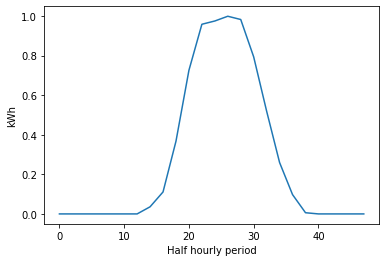

Annual Solar Generation: 3381.96 kWh


In [3]:
# import data
solar_profile = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/OXEMF/data/solar_example.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile[4752:4800])  # just plotting a single day from the entire year
plt.ylabel("kWh")
plt.xlabel("Half hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))

Create Electrolyzer Class

In [13]:
class electrolyzer:
    def __init__(self,elec_price, production_rate,install_cost,max_power,min_power_percentage):
        self.elec_price = elec_price             #GBP Per kWh
        self.production_rate = production_rate   #kg of hydrogen produced per second per MW of electricity
        self.install_cost = install_cost         #in GBP
        self.max_power = max_power               #in MW
        self.min_power = max_power*min_power_percentage/100  #in MW, minimum power to retain its ability to ramp up and down quickly          
        
    def getOpcost(self):
        total_costs = self.elec_price
        Opcost = total_costs*self.production_rate
        return Opcost

ITM HGas3SP Electrolyzer created below

In [15]:
itm_H3GSP = electrolyzer(0.1437, (5/9), 2677440, 2,5)


0.1

Use a day as experimental sample

In [31]:
solar_profile = solar_profile[4752:4800]

Power = solar_profile*2*0.001                   #Average power(MW) of solar grid in the half hour period

H_produced = Power*itm_H3GSP.production_rate   #Hydrogen Produced (kg) in each half hour period

In [32]:
T = len(solar_profile)                    # no. of half hour periods
grid_demand = np.zeros((T,1))

for j in range(T):
    if Power[j] >= itm_H3GSP.min_power:
        H_produced[j] = Power[j]*itm_H3GSP.production_rate 
    else: 
        H_produced[j] = itm_H3GSP.min_power*itm_H3GSP.production_rate
        grid_demand[j] = itm_H3GSP.min_power - Power[j] 
        
Elec_cost = 160.3  #GBP per MWh
Total_cost = Elec_cost * sum(grid_demand*0.5*160.3)
Total_cost


array([61319.55601842])

Code for Hydrogen Storage

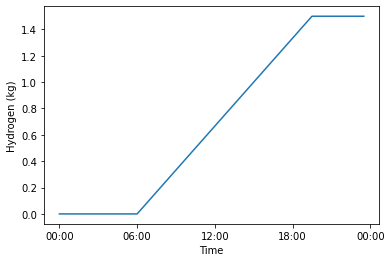

In [33]:
hydrogen_capacity = 10  # kg

T = len(solar_profile)                    # no. of half hour periods
outputi = np.zeros((T,1))  # hydrogen production flow
soc = np.zeros((T,1))  # weight of hydrogen stored


for j in range(T):
    if j == 0:
        socval = 0 
    else:
        socval = soc[j-1]                 #stores soc from the previous timeslot
    
    # if there is production of hydrogen
    if Power[j] > 0:      
        outputi[j] = H_produced[j]
        soc[j] = socval + outputi[j]     #battery is being discharged so soc decreases
        
    # if there is no production of hydrogen
    elif solar_profile[j] == 0: 
        soc[j] = socval                     # battery soc has no change

        
ax = plt.subplot(1,1,1)
p = plt.plot(soc)

plt.xticks([0,12,24,36,48])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('Hydrogen (kg)', color='k')
plt.xlabel('Time', color='k')
plt.show()